In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

In [2]:
def synthetic_mean_reverting(batch_size: int, T: int, n:int, X_0: float, sigma_x: float, kappa: float):
    price_paths = torch.zeros(batch_size, n)
    
    price_paths[:,0] = X_0
    delta_t = T/n

    for i in range(1,n):
        price_paths[:,i] = price_paths[:,i-1] + kappa*(X_0-price_paths[:,i-1])*delta_t + sigma_x*price_paths[:,i-1]*torch.randn(batch_size)*np.sqrt(delta_t)

    return price_paths

def synthetic_drift(drift: float, batch_size: int, T: int, n:int, X_0: float, sigma_x: float):
    price_paths = torch.zeros(batch_size, n)
    
    price_paths[:,0] = X_0
    delta_t = T/n
    drift_term = drift*delta_t

    for i in range(1,n):
        price_paths[:,i] = price_paths[:,i-1] + drift_term + sigma_x*price_paths[:,i-1]*torch.randn(batch_size)*np.sqrt(delta_t)

    return price_paths

In [3]:
X_0 = 100
sigma_x = 0.1
kappa = 1000
batch_size = 1000
T = 1 * 1/252 # time horizon
n = 8*60 # number of time steps
synthetic_batch_stock_data = synthetic_mean_reverting(batch_size, T, n, X_0, sigma_x, kappa)
info_data = torch.zeros(batch_size, n, 0) # no info
# unsqueeze to get a batch dimension
synthetic_batch_stock_data = synthetic_batch_stock_data.unsqueeze(2)

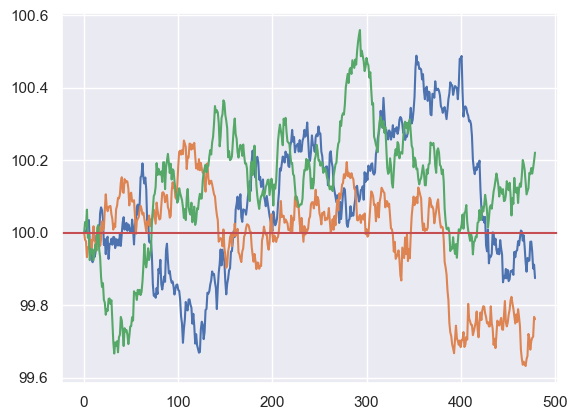

In [4]:
n_plots = 3
for i in range(n_plots):
    plt.plot(synthetic_batch_stock_data[i].numpy())
plt.axhline(y=X_0, color='r', linestyle='-')
plt.show()

# Depth = 1 should yield Markowitz

In [24]:
depth = 1
delta = 0.1
ts = trading_strategy.TradingStrategy(depth, delta)
in_sample_stock, out_of_sample_stock = synthetic_batch_stock_data[:-10], synthetic_batch_stock_data[-10:]
in_sample_info, out_of_sample_info = info_data[:-10], info_data[-10:]
ts.fit(in_sample_stock, in_sample_info)

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.



In [25]:
ts.mu_sig

tensor([ 0.0035, -0.0024,  0.2254])

In [15]:
ts.sigma_sig

tensor([[ 0.0536,  0.0414, -0.0001],
        [ 0.0414,  0.0459, -0.0003],
        [-0.0001, -0.0003,  0.0014]])

## In sample

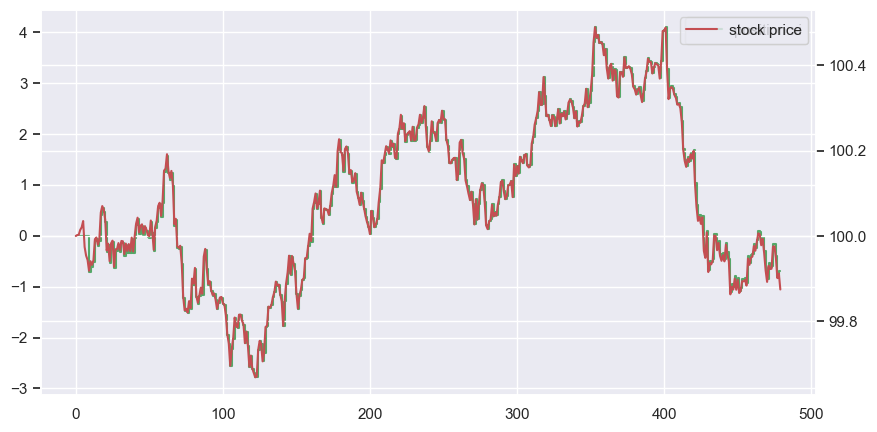

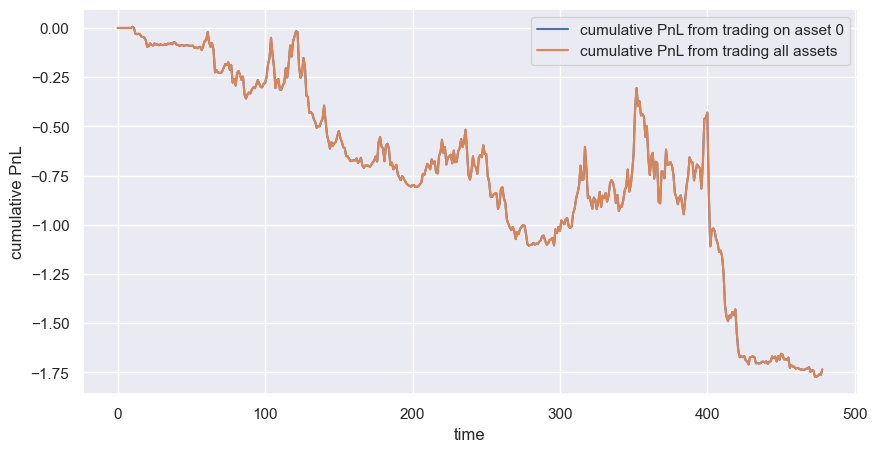

In [12]:
path_index = 0 # path we want to look at
seen_stock_data = in_sample_stock[path_index]
seen_info = in_sample_info[path_index]

# let's trade on this path
xi = ts.trade(seen_stock_data, seen_info, min_steps=10)
daily_pnl = ts.compute_pnl(seen_stock_data, xi)
cum_pnl = torch.cumsum(daily_pnl, dim=0)

# convert xi to numpy array
xi_np = xi.detach().numpy()
# plot xi
plt.figure(figsize=(10,5))
plt.step(np.arange(len(xi_np)), xi_np, color='g', label='position xi')
plt.legend()
plt.twinx()
plt.plot(seen_stock_data, color='r', label='stock price')
plt.legend()
plt.show()

utils.plot_cum_pnl(cum_pnl)

## Out of sample

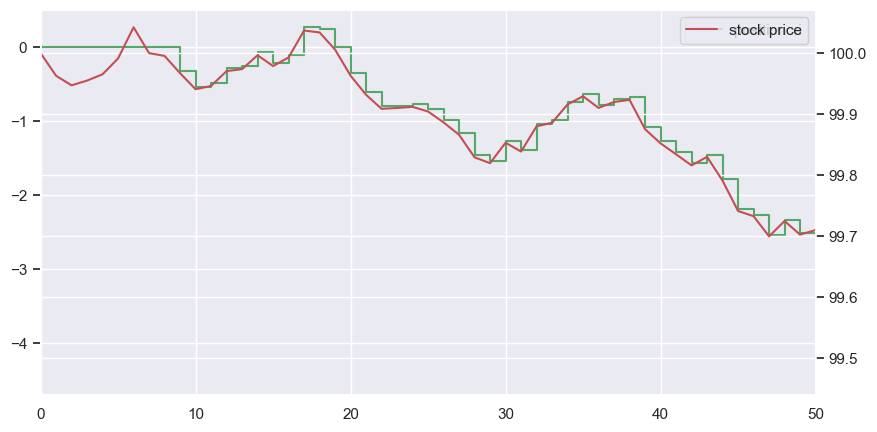

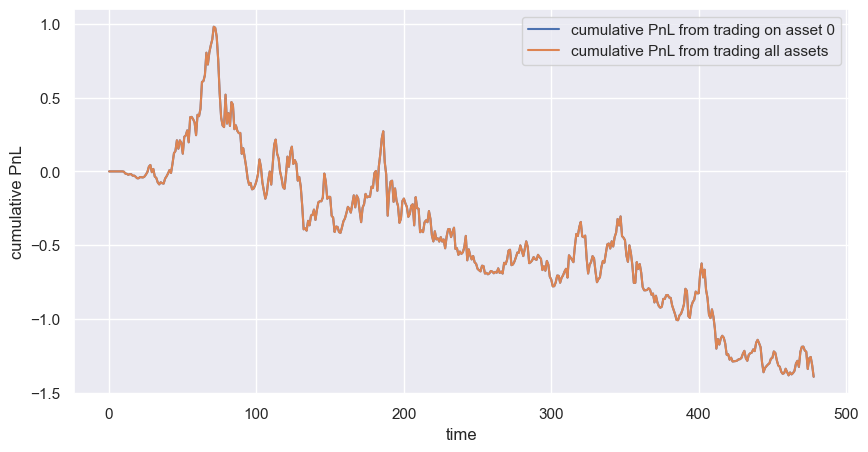

In [10]:
path_index = 0 # path we want to look at
unseen_stock_data = out_of_sample_stock[path_index]
unseen_info = out_of_sample_info[path_index]

# let's trade on this path
xi = ts.trade(unseen_stock_data, unseen_info, min_steps=10)
daily_pnl = ts.compute_pnl(unseen_stock_data, xi)
cum_pnl = torch.cumsum(daily_pnl, dim=0)

# convert xi to numpy array
xi_np = xi.detach().numpy()
# plot xi
plt.figure(figsize=(10,5))
plt.step(np.arange(len(xi_np)), xi_np, color='g', label='position xi')
plt.legend()
plt.twinx()
plt.plot(unseen_stock_data, color='r', label='stock price')
plt.legend()

plt.xlim(0, 50)

plt.show()

utils.plot_cum_pnl(cum_pnl)